# **Dynamic Beamforming Optimization Using Genetic Algorithm for Mobile Devices, Fleets, and Drones**

**Import Packages**

In [1]:
#!pip install numpy 
#!pip install nbformat 
#!pip install matplotlib

import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go #for 3D plot
import concurrent.futures
import multiprocessing
import os
from plotly.subplots import make_subplots

# **MIMO-beamforming**

In [34]:
# Constants
c = 3e8  # Speed of light (m/s)
fc = 28e9  # Carrier frequency (Hz)
wavelength = c / fc  # Wavelength (meters)
d = wavelength / 2  # Distance between antenna elements (half-wavelength spacing)
Nx, Ny = 8, 8  # Number of antenna elements in the x and y dimensions (URA)
codebook_size_azimuth = 32  # Number of beams in the azimuth direction
codebook_size_elevation = 16  # Number of beams in the elevation direction
z_max = 0  # Height of the base station on the z-axis

# Generate 3D steering vectors for a URA (Uniform Rectangular Array)
def steering_vector_3d(azimuth_rad, elevation_rad, Nx, Ny, d, wavelength):
    nx = np.arange(Nx)  # Antenna elements in the x-axis
    ny = np.arange(Ny)  # Antenna elements in the y-axis
    steering_x = np.exp(-1j * 2 * np.pi * d * nx * np.sin(elevation_rad) * np.cos(azimuth_rad) / wavelength)
    steering_y = np.exp(-1j * 2 * np.pi * d * ny * np.sin(azimuth_rad) / wavelength)
    return np.kron(steering_x, steering_y)

# Generate the codebook of 3D beamforming vectors
def generate_3d_codebook(Nx, Ny, d, wavelength, codebook_size_azimuth, codebook_size_elevation):
    codebook = []
    azimuth_angles = np.linspace(-np.pi, np.pi, codebook_size_azimuth)  # Full azimuth angles
    elevation_angles = np.linspace(0, -np.pi/2, codebook_size_elevation)  # Lower hemisphere
    for elevation in elevation_angles:
        for azimuth in azimuth_angles:
            codebook.append(steering_vector_3d(azimuth, elevation, Nx, Ny, d, wavelength))
    return np.array(codebook), azimuth_angles, elevation_angles

# User location in the lower hemisphere
user_azimuth_deg = 30  # User's azimuth angle
user_elevation_deg = -26  # User's elevation angle
user_azimuth_rad = np.deg2rad(user_azimuth_deg)
user_elevation_rad = np.deg2rad(user_elevation_deg)

# Create the 3D codebook
codebook, azimuth_angles, elevation_angles = generate_3d_codebook(Nx, Ny, d, wavelength, codebook_size_azimuth, codebook_size_elevation)

# Channel between the base station and the user
h = steering_vector_3d(user_azimuth_rad, user_elevation_rad, Nx, Ny, d, wavelength)  # User's channel vector

# Calculate received signal power for each beam in the 3D codebook
received_power = []
for beam in codebook:
    received_signal = np.dot(beam.conj().T, h) #-----> for simulating receiving signal dot product is done b/w weight vectors from code book and actual needed weight vector
    power = np.abs(received_signal) ** 2
    received_power.append(power)

# Reshape received power to 2D grid
received_power = np.array(received_power).reshape((codebook_size_elevation, codebook_size_azimuth))

best_beam_idx = np.unravel_index(np.argmax(received_power), received_power.shape)
best_azimuth_angle = np.rad2deg(azimuth_angles[best_beam_idx[1]])
best_elevation_angle = np.rad2deg(elevation_angles[best_beam_idx[0]])

# Prepare data for Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=[0], y=[0], z=[z_max],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Base Station'
))


beam_length = 30
for i, elevation in enumerate(elevation_angles):
    for j, azimuth in enumerate(azimuth_angles):
        x = beam_length * np.cos(elevation) * np.sin(azimuth)
        y = beam_length * np.cos(elevation) * np.cos(azimuth)
        z = beam_length * np.sin(elevation)

        fig.add_trace(go.Scatter3d(
            x=[0, x], y=[0, y], z=[z_max, z],
            mode='lines',
            line=dict(color='blue', width=2),
            name='Beam',
            opacity=0.5
        ))

        # Bullet markers at the end of each beam
        fig.add_trace(go.Scatter3d(
            x=[x], y=[y], z=[z],
            mode='markers',
            marker=dict(size=5, color='blue'),
            name='End of Beam'
        ))

# User position
user_x = beam_length * np.cos(user_elevation_rad) * np.sin(user_azimuth_rad)
user_y = beam_length * np.cos(user_elevation_rad) * np.cos(user_azimuth_rad)
user_z = beam_length * np.sin(user_elevation_rad)  # User is below the base station
fig.add_trace(go.Scatter3d(
    x=[user_x], y=[user_y], z=[user_z],
    mode='markers',
    marker=dict(size=10, color='green'),
    name='User'
))

# Highlight the best beam
best_x = beam_length * np.cos(np.deg2rad(best_elevation_angle)) * np.sin(np.deg2rad(best_azimuth_angle))
best_y = beam_length * np.cos(np.deg2rad(best_elevation_angle)) * np.cos(np.deg2rad(best_azimuth_angle))
best_z = beam_length * np.sin(np.deg2rad(best_elevation_angle))
fig.add_trace(go.Scatter3d(
    x=[0, best_x], y=[0, best_y], z=[z_max, best_z],
    mode='lines',
    line=dict(color='red', width=4),
    name='Best Beam',
    opacity=1 
))

# Layout settings
fig.update_layout(
    scene=dict(
        xaxis_title='X (Azimuth)',
        yaxis_title='Y (Azimuth)',
        zaxis_title='Z (Elevation)',
    ),
    title=f'3D Beamforming: User at {user_azimuth_deg}°, {user_elevation_deg}°',
    showlegend=True
)

fig.show()

print(f'Best beam azimuth angle: {best_azimuth_angle:.2f} degrees')
print(f'Best beam elevation angle: {best_elevation_angle:.2f} degrees')

Best beam azimuth angle: 29.03 degrees
Best beam elevation angle: -24.00 degrees


# **Modified Genetic Algorithm for dynamic beamforming**

**Initial Dataset: Time Varying Inverse Ackley Function**

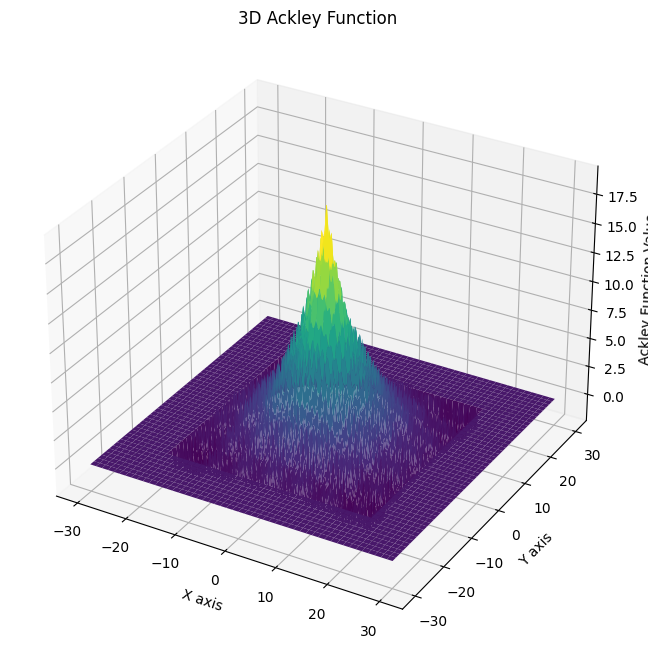

In [2]:
def ackley(x, y): 
    # Compute the Ackley function value for inputs x and y.
    result = 20 - (-20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20)
    
    # Create a mask to limit x and y within the range [-20, 20].
    mask = (x >= -20) & (x <= 20) & (y >= -20) & (y <= 20)
    
    # Set result to 0 for values of x and y outside the defined range.
    result[~mask] = 0
    
    # Return the computed result.
    return result              

# Generate 400 evenly spaced values between -30 and 30 for x and y.
x = np.linspace(-30, 30, 400)
y = np.linspace(-30, 30, 400)

# Create a 2D grid of x and y values.
X, Y = np.meshgrid(x, y)

# Calculate the Ackley function values over the grid.
Z = ackley(X, Y)

# Create a figure for 3D plotting.
fig = plt.figure(figsize=(12, 8))

# Add a 3D subplot to the figure.
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the Ackley function using the 'viridis' colormap.
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set the title and labels for the axes.
ax.set_title('3D Ackley Function')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Ackley Function Value')

# Display the plot.
plt.show()

**Dataset Modified for Real world condition: Time Varying Inverse Ackley Function With Channel Impairments**

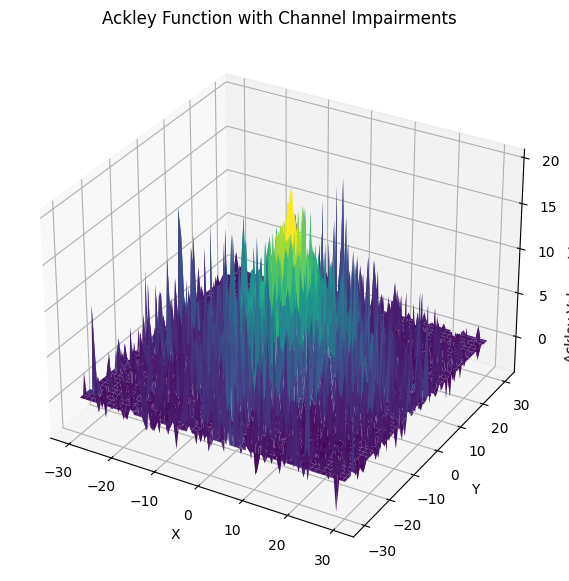

In [3]:
# Function to introduce AWGN noise
def add_awgn_noise(x, snr_db):
    snr_linear = 10**(snr_db / 10.0)
    power_signal = np.mean(x**2)
    power_noise = power_signal / snr_linear
    noise = np.random.normal(0, np.sqrt(power_noise), x.shape)
    return x + noise

# Rayleigh fading
def apply_rayleigh_fading(x):
    return x * np.random.rayleigh(scale=1.0, size=x.shape)

# Rician fading
def apply_rician_fading(x, k_factor=3):
    s = np.sqrt(k_factor / (k_factor + 1))
    sigma = np.sqrt(1 / (2 * (k_factor + 1)))
    fading = np.random.normal(loc=s, scale=sigma, size=x.shape)
    return x * fading

# Nakagami-m fading
def apply_nakagami_fading(x, m=1):
    omega = 1  # Omega is a scaling parameter
    fading = np.random.gamma(m, omega/m, x.shape)
    return x * fading

# Co-channel interference
def add_co_channel_interference(x, interference_level=0.1):
    interference = np.random.normal(0, interference_level, x.shape)
    return x + interference

# Modified Ackley function with multimodality and impairments
def ackley_with_impairments(x, start_time, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1):
    # Apply time decay
    x = x - 0.5 * (time.time() - start_time)

    # Apply impairments
    x = add_awgn_noise(x, snr_db)

    if fading_type == 'rayleigh':
        x = apply_rayleigh_fading(x)
    elif fading_type == 'rician':
        x = apply_rician_fading(x)
    elif fading_type == 'nakagami':
        x = apply_nakagami_fading(x, m=nakagami_m)

    # Add co-channel interference
    x = add_co_channel_interference(x, interference_level)

    # Check if the input is within bounds
    if np.all(x >= -20) and np.all(x <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x)

        # Compute sum terms for the Ackley function
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))

        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)

        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x).sum()

        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

# The previously defined ackley_with_impairments function
# Generate mesh grid for 2D visualization
def visualize_ackley_with_impairments():
    # Define a grid of points over which to evaluate the function
    x_range = np.linspace(-30, 30, 100)
    y_range = np.linspace(-30, 30, 100)
    X, Y = np.meshgrid(x_range, y_range)

    # Start time for time-dependent decayc
    start_time = time.time()

    # Compute function values for each (x, y) pair
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Create a 2D input vector
            x_input = np.array([X[i, j], Y[i, j]])
            Z[i, j] = ackley_with_impairments(x_input, start_time, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1)

    # Plot the surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Ackley Value with Impairments')
    ax.set_title('Ackley Function with Channel Impairments')

    # Show the plot
    plt.show()

# Call the visualization function
visualize_ackley_with_impairments()

**Modified Dataset Simulation: Time Varying Inverse Ackley Function With Channel Impairments**

In [ ]:
# Function to introduce AWGN noise
def add_awgn_noise(x, snr_db):
    snr_linear = 10**(snr_db / 10.0)
    power_signal = np.mean(x**2)
    power_noise = power_signal / snr_linear
    noise = np.random.normal(0, np.sqrt(power_noise), x.shape)
    return x + noise

# Rayleigh fading
def apply_rayleigh_fading(x):
    return x * np.random.rayleigh(scale=1.0, size=x.shape)

# Rician fading
def apply_rician_fading(x, k_factor=3):
    s = np.sqrt(k_factor / (k_factor + 1))
    sigma = np.sqrt(1 / (2 * (k_factor + 1)))
    fading = np.random.normal(loc=s, scale=sigma, size=x.shape)
    return x * fading

# Nakagami-m fading
def apply_nakagami_fading(x, m=1):
    omega = 1  # Omega is a scaling parameter
    fading = np.random.gamma(m, omega/m, x.shape)
    return x * fading

# Co-channel interference
def add_co_channel_interference(x, interference_level=0.1):
    interference = np.random.normal(0, interference_level, x.shape)
    return x + interference

# Modified Ackley function with multimodality and impairments
def ackley_with_impairments(x, start_time, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1, radius=200, angular_speed=0.1):
    # Apply circular motion based on time
    time_elapsed = time.time() - start_time
    theta = angular_speed * time_elapsed  # Angular position over time
    
    # Modify x for circular path
    x_circular = radius * np.array([np.cos(theta), np.sin(theta)]) + x[:2]  # Assume x is at least 2-dimensional
    
    # Apply impairments
    x_circular = add_awgn_noise(x_circular, snr_db)
    
    if fading_type == 'rayleigh':
        x_circular = apply_rayleigh_fading(x_circular)
    elif fading_type == 'rician':
        x_circular = apply_rician_fading(x_circular)
    elif fading_type == 'nakagami':
        x_circular = apply_nakagami_fading(x_circular, m=nakagami_m)
    
    # Add co-channel interference
    x_circular = add_co_channel_interference(x_circular, interference_level)
    
    # Check if the input is within bounds
    if np.all(x_circular >= -20) and np.all(x_circular <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x_circular)
        
        # Compute sum terms for the Ackley function
        sum1 = np.sum(x_circular**2)
        sum2 = np.sum(np.cos(c * x_circular))
        
        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        
        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x_circular).sum()
        
        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

# Example use (assuming add_awgn_noise, apply_rayleigh_fading, etc. are defined):
# start_time = time.time()
# result = ackley_with_impairments(np.array([1.0, 1.0]), start_time)


# Generate mesh grid and continuous update
def visualize_ackley_with_impairments():
    # Define a grid of points over which to evaluate the function
    x_range = np.linspace(-300, 300, 100)
    y_range = np.linspace(-300, 300, 100)
    X, Y = np.meshgrid(x_range, y_range)

    # Start time for time-dependent decay
    start_time = time.time()
    
    # Initialize Z values (Ackley function values)
    Z = np.zeros_like(X)

    # Create a figure with Plotly
    fig = go.Figure(
        data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')],
        layout=go.Layout(
            title='Ackley Function with Channel Impairments',
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Ackley Value with Impairments',
            ),
            updatemenus=[dict(type="buttons", showactive=False)]
        )
    )
    
    # Update Z values in real-time
    frames = []
    for t in range(100):
        # Update the Z values at each time step
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                x_input = np.array([X[i, j], Y[i, j]])
                Z[i, j] = ackley_with_impairments(x_input, start_time, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1)
        
        # Append new frame to the animation
        frames.append(go.Frame(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')]))

    # Add frames to the figure
    fig.frames = frames

    # Define the animation settings
    fig.update_layout(
        updatemenus=[{
            'type': 'buttons',
            'buttons': [
                {
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
                },
                {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]
                }
            ]
        }]
    )
    
    # Show the plot with continuous updates
    fig.show()

# Call the visualization function
visualize_ackley_with_impairments()

**Model: All the function definitions required to simulate the genetic algorithm**

In [5]:
# Compute the Euclidean distance between two points.
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Generate possible gene values and binary representation of genes.
def gene_generator(min_range, max_range, m, n):
    num_of_genes = 2**n - 1
    interval = (max_range - min_range) / num_of_genes
    gene_value = []
    for i in range(num_of_genes+1):
        gene_value.append(min_range+i*interval)
    gene = [[*bin(i)[2:].zfill(n)] for i in range(0, num_of_genes+1)]
    return gene_value, gene

# Griewank function used as an objective function.
def griewank(x, start_time):
    x = x - (time.time()-start_time)/2
    sum_term = np.sum(x**2 / 4000)
    prod_term = np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1))))
    return float(1 + sum_term - prod_term)

# Rosenbrock function used as an objective function.
def rosenbrock(x, a=1, b=100):
    sum_term = np.sum((a - x[:-1])**2)
    prod_term = np.sum(b * (x[1:] - x[:-1]**2)**2)
    return (sum_term + prod_term)

# Sphere function used as an objective function.
def sphere(x):
    return np.sum(x**2)

# Ackley function used as an objective function. Adjust x based on elapsed time since start_time.
# Function to introduce AWGN noise
def add_awgn_noise(x, snr_db):
    snr_linear = 10**(snr_db / 10.0)
    power_signal = np.mean(x**2)
    power_noise = power_signal / snr_linear
    noise = np.random.normal(0, np.sqrt(power_noise), x.shape)
    return x + noise

# Rayleigh fading
def apply_rayleigh_fading(x):
    return x * np.random.rayleigh(scale=1.0, size=x.shape)

# Rician fading
def apply_rician_fading(x, k_factor=3):
    s = np.sqrt(k_factor / (k_factor + 1))
    sigma = np.sqrt(1 / (2 * (k_factor + 1)))
    fading = np.random.normal(loc=s, scale=sigma, size=x.shape)
    return x * fading

# Nakagami-m fading
def apply_nakagami_fading(x, m=1):
    omega = 1  # Omega is a scaling parameter
    fading = np.random.gamma(m, omega/m, x.shape)
    return x * fading

# Co-channel interference
def add_co_channel_interference(x, interference_level=0.1):
    interference = np.random.normal(0, interference_level, x.shape)
    return x + interference

# Modified Ackley function with multimodality and impairments
def ackley(x, start_time, ti, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1):
    # Apply time decay
    x = x - 0.5 * (ti - start_time)
    
    # Apply impairments
    x = add_awgn_noise(x, snr_db)
    
    if fading_type == 'rayleigh':
        x = apply_rayleigh_fading(x)
    elif fading_type == 'rician':
        x = apply_rician_fading(x)
    elif fading_type == 'nakagami':
        x = apply_nakagami_fading(x, m=nakagami_m)
    
    # Add co-channel interference
    x = add_co_channel_interference(x, interference_level)
    
    # Check if the input is within bounds
    if np.all(x >= -20) and np.all(x <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x)
        
        # Compute sum terms for the Ackley function
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        
        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        
        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x).sum()
        
        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

# Rastrigin function used as an objective function.
def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# Zakharov function used as an objective function.
def zakharov(x):
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * np.arange(1, len(x) + 1) * x)
    return sum1 + sum2**2 + sum2**4

# Function to generate values for the population based on the given objective function.
def population_value_generator(obj_fun, population, x_gene_value, y_gene_value, z_gene_value, start_time, ti):
    population_values = []
    obj_func_values = []
    for chromosome in population: # Evaluate each chromosome in the population
        chromosome_values = []
        dim = 0
        for gene in chromosome:
            bin_str = ''.join(map(str, gene))
            dec_num = int(bin_str, 2)
            if dim == 0:
                chromosome_values.append(x_gene_value[dec_num])
            if dim == 1:
                chromosome_values.append(y_gene_value[dec_num])
            if dim == 2:
                chromosome_values.append(z_gene_value[dec_num])
            dim += 1
        if obj_fun == "Griewank":
            obj_func_value = griewank(np.array(chromosome_values), start_time)
        elif obj_fun == "Rosenbrock":
            obj_func_value = rosenbrock(np.array(chromosome_values))
        elif obj_fun == "Ackley":
            obj_func_value = ackley(np.array(chromosome_values),start_time, ti)
        elif obj_fun == "Sphere":
            obj_func_value = sphere(np.array(chromosome_values))
        elif obj_fun == "Rastrigin":
            obj_func_value = rastrigin(np.array(chromosome_values))
        elif obj_fun == "Zakharov":
            obj_func_value = zakharov(np.array(chromosome_values))
        else:
            print("Give Correct Objective Function") 
        obj_func_values.append(obj_func_value)
        population_values.append(chromosome_values)
    return population_values, obj_func_values

# Select a subset of the population based on objective function values and optimization goal.
def thresholding(optm, obj_func_values, threshold):
    if optm == "min":
        selected_population_ind = np.argsort(obj_func_values)[:threshold]
    elif optm == "max":
        selected_population_ind = np.argsort(obj_func_values)[::-1][:threshold] #[:threshold]
    else:
        print("Define optimisation as maximise or minimise")
    return selected_population_ind

# Estimate fitness values for the selected population.
def fitness_estimation(selected_population, obj_func_values):
    fitness_values = []
    for ind in selected_population:
        #fitness = 1/(1 + obj_func_values[ind])
        fitness = (obj_func_values[ind])**4
        fitness_values.append(fitness)
    return(fitness_values)

 # Perform roulette wheel selection based on fitness values.
def Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child):    
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    ranks = np.zeros_like(sorted_indices)
    for rank, index in enumerate(sorted_indices):
        ranks[index] = rank + 1
    
    rank_sum = sum(ranks)
    fitness_probability = [(rank / rank_sum) for rank in ranks]  # Add a small value to avoid zero probability
    
    parents = set()
    while len(parents) < no_of_child:
        parent = np.random.choice(selected_population_ind, p=fitness_probability, size=2, replace=False).tolist()
        parents.add(tuple(parent))
    
    return tuple(parents)

# Perform crossover operation to generate children from parent chromosomes.
def crossover(parents, population, m):
    children = []
    for parent in parents:
        cross_pt = np.random.randint(1, m)
        child = np.concatenate((population[parent[0]][:cross_pt], population[parent[1]][cross_pt:]))
        children.append(child)
    return children

# Perform mutation on the children chromosomes.
def mutation(children,m,n):
    mutated_children = []
    for child in children:
        m_mutate = np.random.randint(0, m)
        n_mutate = np.random.randint(0, n)
        if child[m_mutate][n_mutate] == 0:
            child[m_mutate][n_mutate] = 1
        else:
            child[m_mutate][n_mutate] = 0
        mutated_children.append(child)
    return mutated_children

#Genetic Algorithm Definition

def genetic_algorithm(file_name, seed, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, obj_fun, num_of_mutation, optm, iter, start_time, previous_population, ti):

    #np.random.seed(seed)
    f = []
    g = []
    f_lists = [[] for _ in range(p)]

    x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
    y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
    z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
    
    population  = previous_population

    for i in range(iter):

        population_values, obj_func_values = population_value_generator(obj_fun, population, x_gene_value, y_gene_value, z_gene_value, start_time, ti)
            
        #Monitoring Variables
        for j, value in enumerate(obj_func_values):
            f_lists[j].append(value)
        if optm == "min":
            f.append(min(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        elif optm == "max":
            f.append(max(obj_func_values))
            g.append(population_values[obj_func_values.index(max(obj_func_values))])
        else:
            print("Define optimisation as maximise or minimise")

        #Thresholding
        selected_population_ind = thresholding(optm, obj_func_values, threshold)
        selected_population = []
        for i in selected_population_ind:
            selected_population.append(population[i])

        #Fitness Estimation
        fitness_values = fitness_estimation(selected_population_ind, obj_func_values)

        #Roulette_wheel
        parents = Roulette_wheel(selected_population_ind, fitness_values, threshold, no_of_child)

        # Crossover
        children = crossover(parents, population, m)
           
        if num_of_mutation == 0:
            new_children = children
        else:
            for i in range(num_of_mutation):
                new_children = mutation(children, m, n) #Issue with mutation. Mutate at many places
            
        # New Population
        population = selected_population + new_children
        
    value = f[len(f)-1]
    location = g[len(g)-1]
    index = f.index(value) + 1
    score = 100/(1+(index*value))
    result = {"value": value, "iteration": index, "location": location}
    fs = {"f": f, "f_lists": f_lists}
    
    return result, fs, population


# **Mobile Station moving with constant velocity at 0.5 units/s**
**Dataset: Mobile station moving with constant velocity at 0.5 unit/s**

**Main Function**

In [ ]:
#Intialisation
start_time = 0
t = list(range(1, 10001))
#start_time = time.time()

errors = []
manual_errors = []
values = []
true_values = []
station_values = []
time_interval = []
est_points = []
actual_points = []

p = 6  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 5 # Number of digits / Alleles
threshold = 3 # Crossover threshold
no_of_child = 3 # Number of childrens 
num_of_mutation = 3 # Number of point of mutation

#Dyamic Range
obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
x_min_range = -10
x_max_range = 10
y_min_range = -10
y_max_range = 10
z_min_range = -10
z_max_range = 10
optm = "max" #"max"

iter = 100
times = 1
file = 'genetic_algorithm_output_steps.txt'

#seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333, 888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,500):
    total_score, total_value, total_iteration = 0, 0, 0
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population #Previous 

    results = genetic_algorithm(file, 42, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, 
                                obj_fun, num_of_mutation, optm, iter, start_time, previous_population, t[it])
            
    result,fs, pre_population = results
    total_value += result['value']
    location = result['location']
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time, t[it])
    station_values.append(station_result)
    
    
    shifted_x = np.array([0, 0, 0]) + 0.5*(t[it] - start_time)
        
    true_result = ackley(shifted_x, start_time, t[it])
    true_values.append(true_result)
        
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    manual_error = euclidean_distance(np.array([0, 0, 0]), shifted_x)
    #time_stamp = time.time() - start_time
    time_stamp = t[it]
    values.append(avg_value)
    errors.append(error)
    manual_errors.append(manual_error)
    time_interval.append(time_stamp)
    est_points.append(location)
    actual_points.append(shifted_x)
    
    print(f"\nTime: {time_stamp}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    
    #Dynamic Range and threshold signal strength to trigger it
    if avg_value < 15 and it>10:
        populate_val = []
        x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
        y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
        z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
        for chromosome in previous_population:
            chromosome_values = []
            dim = 0
            for gene in chromosome:
                bin_str = ''.join(map(str, gene))
                dec_num = int(bin_str, 2)
                if dim == 0:
                    chromosome_values.append(x_gene_value[dec_num])
                if dim == 1:
                    chromosome_values.append(y_gene_value[dec_num])
                if dim == 2:
                    chromosome_values.append(z_gene_value[dec_num])
                dim += 1
            populate_val.append(chromosome_values)
        population_sum = [sum(col) for col in zip(*populate_val[:no_of_child])]
        
        #print(populate_val)
        #print(len(populate_val))
        #print(all_gene_value)
        #print(all_gene)
        min_range = -10
        max_range = 10
        x_min_range = min_range + chromosome_values[0]
        x_max_range = max_range + chromosome_values[0]
        y_min_range = min_range + chromosome_values[1]
        y_max_range = max_range + chromosome_values[1]
        z_min_range = min_range + chromosome_values[2]
        z_max_range = max_range + chromosome_values[2]
        
        print(x_min_range, x_max_range)
        print(y_min_range, y_max_range)
        print(z_min_range, z_max_range)
    
print("\nValue:", values)
print("\nErrors:", errors)
print("\nActual Points", actual_points)
print("\nEstimated  Points", est_points)
print("\nTime Interval", time_interval)

**Output Results**

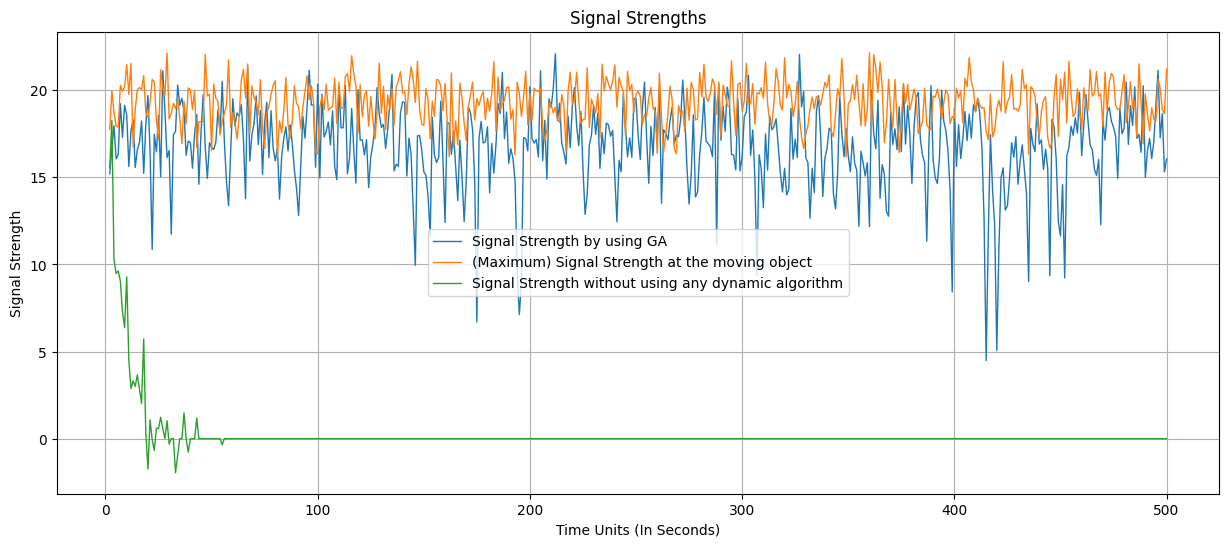

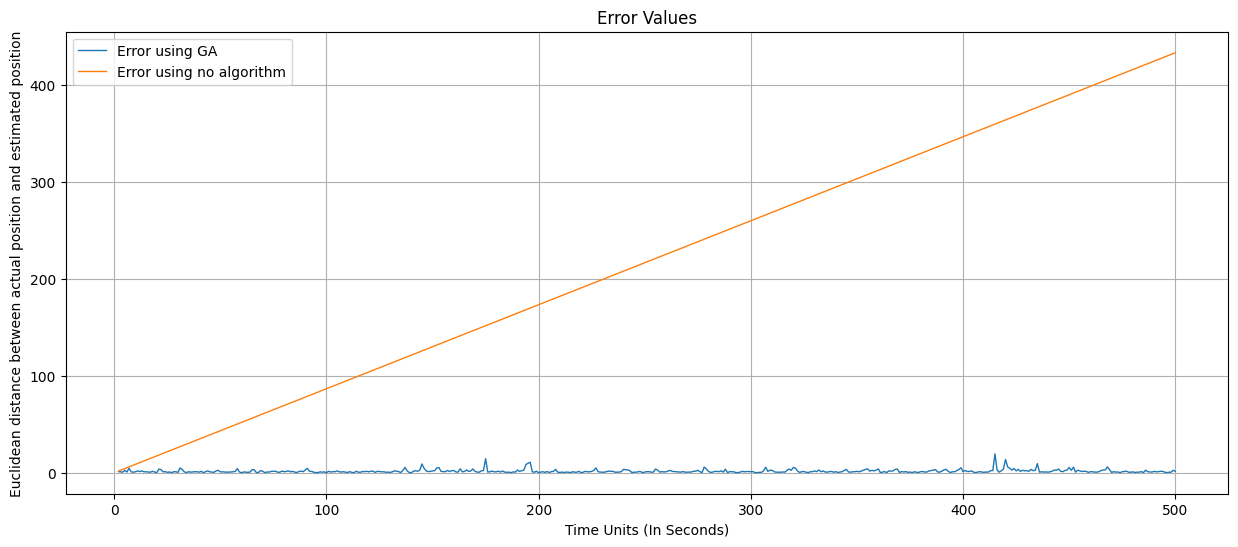

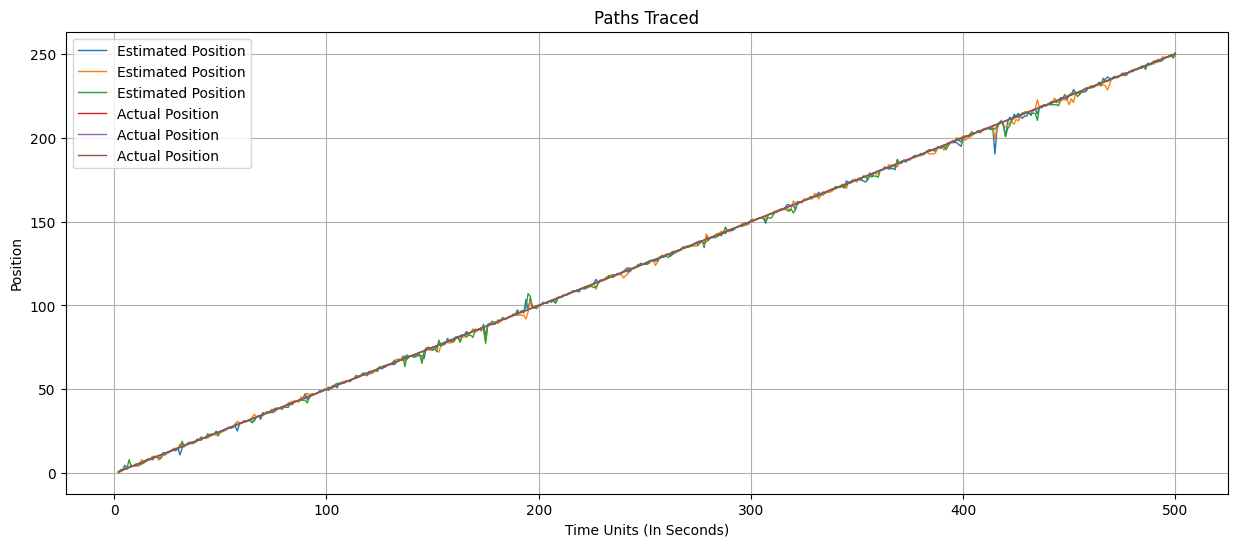

In [8]:
# Create a line plot
signal_strength = values
max_signal_strength = true_values
static_signal_strength = station_values

# Plot Signal Strengths
plt.figure(figsize=(15, 6))
plt.plot(time_interval, signal_strength, linewidth = '1', label="Signal Strength by using GA")
plt.plot(time_interval, max_signal_strength, label="(Maximum) Signal Strength at the moving object",linewidth = '1')
plt.plot(time_interval, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '1')
plt.title('Signal Strengths')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.legend()
plt.show()

#Error Values
plt.figure(figsize=(15, 6))
plt.plot(time_interval, errors, linewidth = '1', label='Error using GA')
plt.plot(time_interval, manual_errors, linewidth = '1', label='Error using no algorithm')
plt.title('Error Values')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Euclidean distance between actual position and estimated position')
plt.grid(True)
plt.legend()
plt.show()

#Paths Traced
plt.figure(figsize=(15, 6))
plt.plot(time_interval, est_points, linewidth = '1', label='Estimated Position')
plt.plot(time_interval, actual_points, linewidth = '1', label='Actual Position')
plt.title('Paths Traced')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.show()

**Output: Simulation of path traced by genetic algorithm**

In [ ]:
def trajectory_to_dict(time, actual_coords, estimated_coords):
    trajectory_dict = {}
    
    for t, actual, estimated in zip(time, actual_coords, estimated_coords):
        trajectory_dict[t] = (actual, estimated)
    
    return trajectory_dict

# Replace this with your actual dictionary containing time, actual, and estimated points
trajectory_data = trajectory_to_dict(time_interval, actual_points, est_points)

# Extract actual and estimated trajectories from the dictionary
actual_trajectory = np.array([val[0] for val in trajectory_data.values()])
estimated_trajectory = np.array([val[1] for val in trajectory_data.values()])
times = list(trajectory_data.keys())

# Base station position
base_station = np.array([-30, 70, 70])

# Create figure
fig = go.Figure()

# Add base station as a red marker, fixed throughout the animation
fig.add_trace(go.Scatter3d(
    x=[base_station[0]], 
    y=[base_station[1]], 
    z=[base_station[2]],
    mode='markers', 
    name='Base Station', 
    marker=dict(size=6, color='red')
))

# Create frames for animation
frames = []
for i in range(len(times)):
    # For each frame, update the plot with actual trajectory, estimated trajectory, and beams
    frame_data = [
        # Base station (included in every frame to remain visible)
        go.Scatter3d(
            x=[base_station[0]], 
            y=[base_station[1]], 
            z=[base_station[2]],
            mode='markers', 
            name='Base Station', 
            marker=dict(size=6, color='red')
        ),
        # Actual trajectory up to the current point
        go.Scatter3d(
            x=actual_trajectory[:i + 1, 0], 
            y=actual_trajectory[:i + 1, 1], 
            z=actual_trajectory[:i + 1, 2],
            mode='lines', 
            name='Actual Trajectory', 
            line=dict(color='green', width=3)
        ),
        # Estimated trajectory up to the current point
        go.Scatter3d(
            x=estimated_trajectory[:i + 1, 0], 
            y=estimated_trajectory[:i + 1, 1], 
            z=estimated_trajectory[:i + 1, 2],
            mode='lines', 
            name='Estimated Trajectory', 
            line=dict(color='blue', width=3)
        ),
        # Beam from base station to the current estimated point
        go.Scatter3d(
            x=[base_station[0], estimated_trajectory[i, 0]], 
            y=[base_station[1], estimated_trajectory[i, 1]], 
            z=[base_station[2], estimated_trajectory[i, 2]], 
            mode='lines', 
            line=dict(color='blue', width=3),
            name='Beam'
        )
    ]
    frames.append(go.Frame(data=frame_data, name=str(i)))

# Initialize the figure with the first frame (starting point)
fig.add_trace(go.Scatter3d(
    x=actual_trajectory[:1, 0], 
    y=actual_trajectory[:1, 1], 
    z=actual_trajectory[:1, 2],
    mode='lines', 
    name='Actual Trajectory', 
    line=dict(color='green', width=3)
))
fig.add_trace(go.Scatter3d(
    x=estimated_trajectory[:1, 0], 
    y=estimated_trajectory[:1, 1], 
    z=estimated_trajectory[:1, 2],
    mode='lines', 
    name='Estimated Trajectory', 
    line=dict(color='blue', width=3)
))
# Add initial beam from base station to the first estimated point
fig.add_trace(go.Scatter3d(
    x=[base_station[0], estimated_trajectory[0, 0]], 
    y=[base_station[1], estimated_trajectory[0, 1]], 
    z=[base_station[2], estimated_trajectory[0, 2]], 
    mode='lines', 
    line=dict(color='blue', width=3),
    name='Beam'
))

# Update layout with a fixed view frame
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        xaxis=dict(range=[-80, 500], autorange=False),  # Set fixed X-axis range
        yaxis=dict(range=[-40, 500], autorange=False),  # Set fixed Y-axis range
        zaxis=dict(range=[0, 500], autorange=False),     # Set fixed Z-axis range
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Mobile Station Trajectory Animation',
    margin=dict(l=0, r=0, b=0, t=0),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 200 / 5, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Set the frames to the figure
fig.frames = frames

# Show the figure
fig.show()

# **Mobile Station accelerating at 0.1 units/s2**
**Dataset: Mobile station accelerating at 0.1 unit/s2**

In [16]:
def ackley(x, start_time, ti, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1):
    # Apply time decay
    x = x - (0.1*(ti - start_time))**2
    
    # Apply impairments
    x = add_awgn_noise(x, snr_db)
    
    if fading_type == 'rayleigh':
        x = apply_rayleigh_fading(x)
    elif fading_type == 'rician':
        x = apply_rician_fading(x)
    elif fading_type == 'nakagami':
        x = apply_nakagami_fading(x, m=nakagami_m)
    
    # Add co-channel interference
    x = add_co_channel_interference(x, interference_level)
    
    # Check if the input is within bounds
    if np.all(x >= -20) and np.all(x <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x)
        
        # Compute sum terms for the Ackley function
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        
        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        
        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x).sum()
        
        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

# Rastrigin function used as an objective function.
def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

# Zakharov function used as an objective function.
def zakharov(x):
    sum1 = np.sum(x**2)
    sum2 = np.sum(0.5 * np.arange(1, len(x) + 1) * x)
    return sum1 + sum2**2 + sum2**4

# Function to generate values for the population based on the given objective function.
def population_value_generator(obj_fun, population, x_gene_value, y_gene_value, z_gene_value, start_time, ti):
    population_values = []
    obj_func_values = []
    for chromosome in population: # Evaluate each chromosome in the population
        chromosome_values = []
        dim = 0
        for gene in chromosome:
            bin_str = ''.join(map(str, gene))
            dec_num = int(bin_str, 2)
            if dim == 0:
                chromosome_values.append(x_gene_value[dec_num])
            if dim == 1:
                chromosome_values.append(y_gene_value[dec_num])
            if dim == 2:
                chromosome_values.append(z_gene_value[dec_num])
            dim += 1
        if obj_fun == "Griewank":
            obj_func_value = griewank(np.array(chromosome_values), start_time)
        elif obj_fun == "Rosenbrock":
            obj_func_value = rosenbrock(np.array(chromosome_values))
        elif obj_fun == "Ackley":
            obj_func_value = ackley(np.array(chromosome_values),start_time, ti)
        elif obj_fun == "Sphere":
            obj_func_value = sphere(np.array(chromosome_values))
        elif obj_fun == "Rastrigin":
            obj_func_value = rastrigin(np.array(chromosome_values))
        elif obj_fun == "Zakharov":
            obj_func_value = zakharov(np.array(chromosome_values))
        else:
            print("Give Correct Objective Function") 
        obj_func_values.append(obj_func_value)
        population_values.append(chromosome_values)
    return population_values, obj_func_values


**Main function**

In [ ]:
#Intialisation
start_time = 0
t = list(range(1, 10001))
#start_time = time.time()

errors = []
manual_errors = []
values = []
true_values = []
station_values = []
time_interval = []
est_points = []
actual_points = []

p = 6  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 5 # Number of digits / Alleles
threshold = 3 # Crossover threshold
no_of_child = 3 # Number of childrens 
num_of_mutation = 3 # Number of point of mutation

#Dyamic Range
obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
x_min_range = -20
x_max_range = 20
y_min_range = -20
y_max_range = 20
z_min_range = -20
z_max_range = 20
optm = "max" #"max"

iter = 100
times = 1
file = 'genetic_algorithm_output_steps.txt'

#seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333, 888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,100):
    total_score, total_value, total_iteration = 0, 0, 0
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population #Previous 

    results = genetic_algorithm(file, 42, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, 
                                obj_fun, num_of_mutation, optm, iter, start_time, previous_population, t[it])
            
    result,fs, pre_population = results
    total_value += result['value']
    location = result['location']
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time, t[it])
    station_values.append(station_result)
    
    
    shifted_x = np.array([0, 0, 0]) + (0.1*(t[it] - start_time))**2
        
    true_result = ackley(shifted_x, start_time, t[it])
    true_values.append(true_result)
        
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    manual_error = euclidean_distance(np.array([0, 0, 0]), shifted_x)
    #time_stamp = time.time() - start_time
    time_stamp = t[it]
    values.append(avg_value)
    errors.append(error)
    manual_errors.append(manual_error)
    time_interval.append(time_stamp)
    est_points.append(location)
    actual_points.append(shifted_x)
    
    print(f"\nTime: {time_stamp}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    
    #Dynamic Range and threshold signal strength to trigger it
    if avg_value < 15 and it>10:
        populate_val = []
        x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
        y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
        z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
        for chromosome in previous_population:
            chromosome_values = []
            dim = 0
            for gene in chromosome:
                bin_str = ''.join(map(str, gene))
                dec_num = int(bin_str, 2)
                if dim == 0:
                    chromosome_values.append(x_gene_value[dec_num])
                if dim == 1:
                    chromosome_values.append(y_gene_value[dec_num])
                if dim == 2:
                    chromosome_values.append(z_gene_value[dec_num])
                dim += 1
            populate_val.append(chromosome_values)
        population_sum = [sum(col) for col in zip(*populate_val[:no_of_child])]
        
        #print(populate_val)
        #print(len(populate_val))
        #print(all_gene_value)
        #print(all_gene)
        min_range = -30
        max_range = 30
        x_min_range = min_range + chromosome_values[0]
        x_max_range = max_range + chromosome_values[0]
        y_min_range = min_range + chromosome_values[1]
        y_max_range = max_range + chromosome_values[1]
        z_min_range = min_range + chromosome_values[2]
        z_max_range = max_range + chromosome_values[2]
        
        print(x_min_range, x_max_range)
        print(y_min_range, y_max_range)
        print(z_min_range, z_max_range)
    
print("\nValue:", values)
print("\nErrors:", errors)
print("\nActual Points", actual_points)
print("\nEstimated  Points", est_points)
print("\nTime Interval", time_interval)

**Output Results**

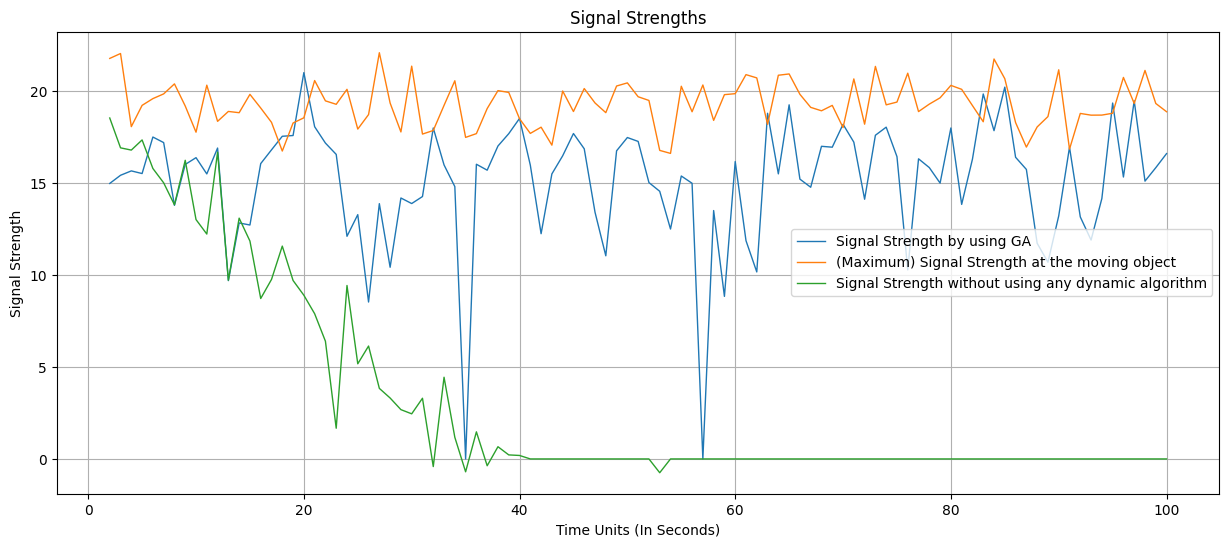

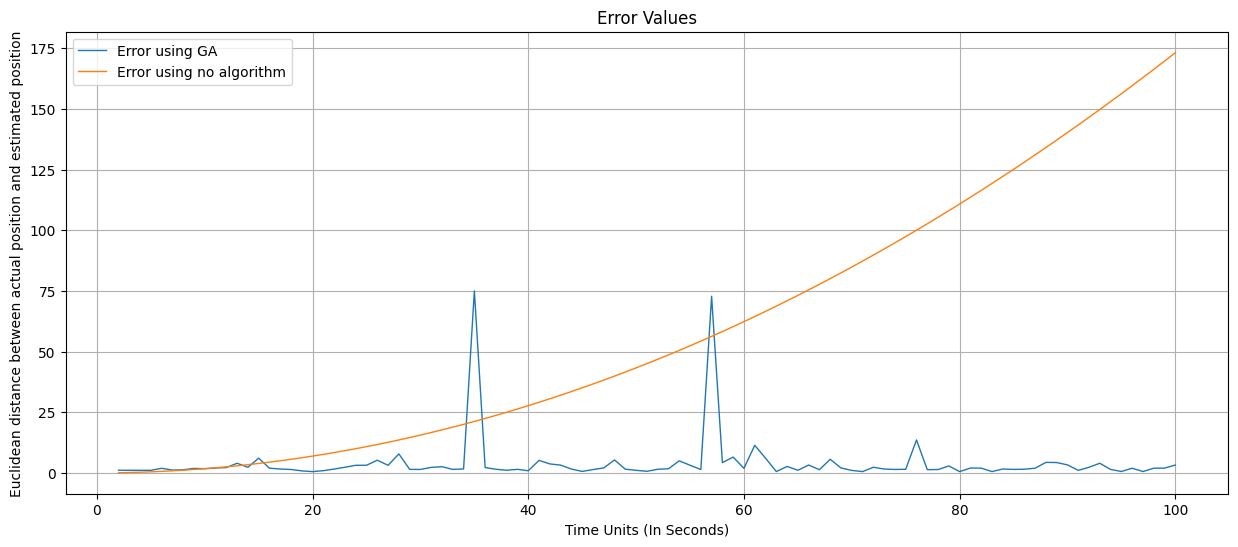

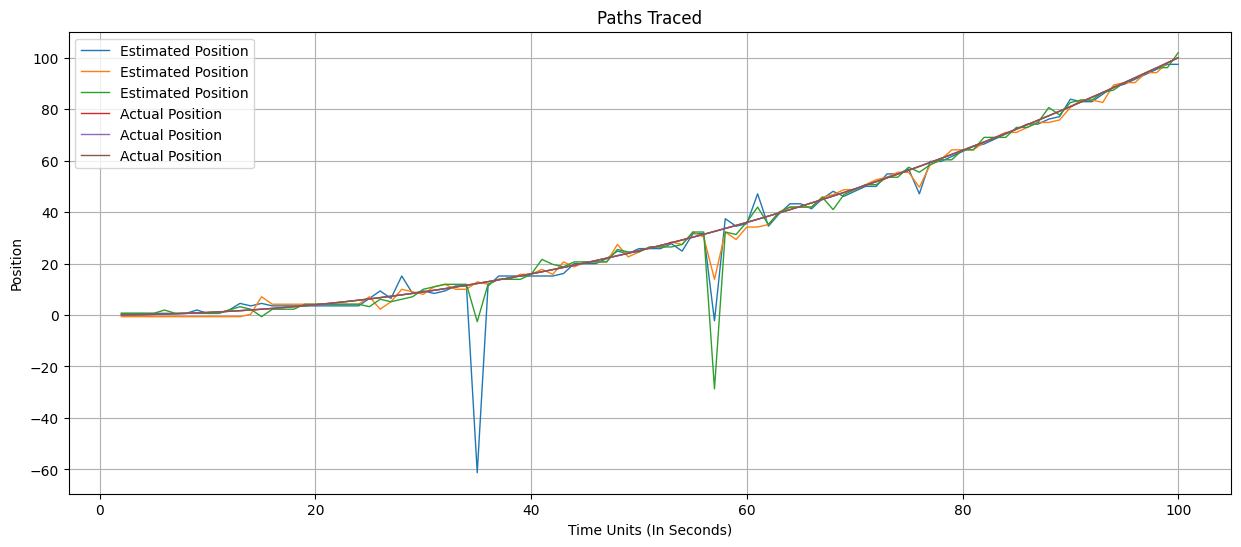

In [24]:
# Create a line plot
signal_strength = values
max_signal_strength = true_values
static_signal_strength = station_values

# Plot Signal Strengths
plt.figure(figsize=(15, 6))
plt.plot(time_interval, signal_strength, linewidth = '1', label="Signal Strength by using GA")
plt.plot(time_interval, max_signal_strength, label="(Maximum) Signal Strength at the moving object",linewidth = '1')
plt.plot(time_interval, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '1')
plt.title('Signal Strengths')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.legend()
plt.show()

#Error Values
plt.figure(figsize=(15, 6))
plt.plot(time_interval, errors, linewidth = '1', label='Error using GA')
plt.plot(time_interval, manual_errors, linewidth = '1', label='Error using no algorithm')
plt.title('Error Values')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Euclidean distance between actual position and estimated position')
plt.grid(True)
plt.legend()
plt.show()

#Paths Traced
plt.figure(figsize=(15, 6))
plt.plot(time_interval, est_points, linewidth = '1', label='Estimated Position')
plt.plot(time_interval, actual_points, linewidth = '1', label='Actual Position')
plt.title('Paths Traced')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.show()

**Output: Simulation of path traced by genetic algorithm**

In [ ]:
def trajectory_to_dict(time, actual_coords, estimated_coords):
    trajectory_dict = {}
    
    for t, actual, estimated in zip(time, actual_coords, estimated_coords):
        trajectory_dict[t] = (actual, estimated)
    
    return trajectory_dict

# Replace this with your actual dictionary containing time, actual, and estimated points
trajectory_data = trajectory_to_dict(time_interval, actual_points, est_points)

# Extract actual and estimated trajectories from the dictionary
actual_trajectory = np.array([val[0] for val in trajectory_data.values()])
estimated_trajectory = np.array([val[1] for val in trajectory_data.values()])
times = list(trajectory_data.keys())

# Base station position
base_station = np.array([-30, 70, 70])

# Create figure
fig = go.Figure()

# Add base station as a red marker, fixed throughout the animation
fig.add_trace(go.Scatter3d(
    x=[base_station[0]], 
    y=[base_station[1]], 
    z=[base_station[2]],
    mode='markers', 
    name='Base Station', 
    marker=dict(size=6, color='red')
))

# Create frames for animation
frames = []
for i in range(len(times)):
    # For each frame, update the plot with actual trajectory, estimated trajectory, and beams
    frame_data = [
        # Base station (included in every frame to remain visible)
        go.Scatter3d(
            x=[base_station[0]], 
            y=[base_station[1]], 
            z=[base_station[2]],
            mode='markers', 
            name='Base Station', 
            marker=dict(size=6, color='red')
        ),
        # Actual trajectory up to the current point
        go.Scatter3d(
            x=actual_trajectory[:i + 1, 0], 
            y=actual_trajectory[:i + 1, 1], 
            z=actual_trajectory[:i + 1, 2],
            mode='lines', 
            name='Actual Trajectory', 
            line=dict(color='green', width=3)
        ),
        # Estimated trajectory up to the current point
        go.Scatter3d(
            x=estimated_trajectory[:i + 1, 0], 
            y=estimated_trajectory[:i + 1, 1], 
            z=estimated_trajectory[:i + 1, 2],
            mode='lines', 
            name='Estimated Trajectory', 
            line=dict(color='blue', width=3)
        ),
        # Beam from base station to the current estimated point
        go.Scatter3d(
            x=[base_station[0], estimated_trajectory[i, 0]], 
            y=[base_station[1], estimated_trajectory[i, 1]], 
            z=[base_station[2], estimated_trajectory[i, 2]], 
            mode='lines', 
            line=dict(color='blue', width=3),
            name='Beam'
        )
    ]
    frames.append(go.Frame(data=frame_data, name=str(i)))

# Initialize the figure with the first frame (starting point)
fig.add_trace(go.Scatter3d(
    x=actual_trajectory[:1, 0], 
    y=actual_trajectory[:1, 1], 
    z=actual_trajectory[:1, 2],
    mode='lines', 
    name='Actual Trajectory', 
    line=dict(color='green', width=3)
))
fig.add_trace(go.Scatter3d(
    x=estimated_trajectory[:1, 0], 
    y=estimated_trajectory[:1, 1], 
    z=estimated_trajectory[:1, 2],
    mode='lines', 
    name='Estimated Trajectory', 
    line=dict(color='blue', width=3)
))
# Add initial beam from base station to the first estimated point
fig.add_trace(go.Scatter3d(
    x=[base_station[0], estimated_trajectory[0, 0]], 
    y=[base_station[1], estimated_trajectory[0, 1]], 
    z=[base_station[2], estimated_trajectory[0, 2]], 
    mode='lines', 
    line=dict(color='blue', width=3),
    name='Beam'
))

# Update layout with a fixed view frame
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        xaxis=dict(range=[-100, 100], autorange=False),  # Set fixed X-axis range
        yaxis=dict(range=[-40, 120], autorange=False),  # Set fixed Y-axis range
        zaxis=dict(range=[0, 120], autorange=False),     # Set fixed Z-axis range
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Mobile Station Trajectory Animation',
    margin=dict(l=0, r=0, b=0, t=0),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 200 / 5, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Set the frames to the figure
fig.frames = frames

# Show the figure
fig.show()

Interesting Note: Despite the GA Looses track of function at time t=37 and t=57, within nect 2-3 seconds it's able to track it back. It's because of the magical properties of dynamic range and mutation. If population size is increased this property can be mitigated.

# **Mobile Station accelerating at 0.1 units/s2 - Improved (Population Size Change from 6 to 10)**

**Dataset: Mobile station accelerating at 0.1 unit/s2**

In [26]:
# Modified Ackley function with multimodality and impairments
def ackley(x, start_time, ti, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1):
    # Apply time decay
    x = x - (0.1*(ti - start_time))**2
    
    # Apply impairments
    x = add_awgn_noise(x, snr_db)
    
    if fading_type == 'rayleigh':
        x = apply_rayleigh_fading(x)
    elif fading_type == 'rician':
        x = apply_rician_fading(x)
    elif fading_type == 'nakagami':
        x = apply_nakagami_fading(x, m=nakagami_m)
    
    # Add co-channel interference
    x = add_co_channel_interference(x, interference_level)
    
    # Check if the input is within bounds
    if np.all(x >= -20) and np.all(x <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x)
        
        # Compute sum terms for the Ackley function
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        
        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        
        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x).sum()
        
        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

**Main Function**

In [ ]:
#Intialisation
start_time = 0
t = list(range(1, 10001))
#start_time = time.time()

errors = []
manual_errors = []
values = []
true_values = []
station_values = []
time_interval = []
est_points = []
actual_points = []

p = 10  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 7 # Number of digits / Alleles
threshold = 3 # Crossover threshold
no_of_child = 3 # Number of childrens 
num_of_mutation = 3 # Number of point of mutation

#Dyamic Range
obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
x_min_range = -20
x_max_range = 20
y_min_range = -20
y_max_range = 20
z_min_range = -20
z_max_range = 20
optm = "max" #"max"

iter = 100
times = 1
file = 'genetic_algorithm_output_steps.txt'

#seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333, 888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,100):
    total_score, total_value, total_iteration = 0, 0, 0
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population #Previous 

    results = genetic_algorithm(file, 42, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, 
                                obj_fun, num_of_mutation, optm, iter, start_time, previous_population, t[it])
            
    result,fs, pre_population = results
    total_value += result['value']
    location = result['location']
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time, t[it])
    station_values.append(station_result)
    
    
    shifted_x = np.array([0, 0, 0]) + (0.1*(t[it] - start_time))**2
        
    true_result = ackley(shifted_x, start_time, t[it])
    true_values.append(true_result)
        
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    manual_error = euclidean_distance(np.array([0, 0, 0]), shifted_x)
    #time_stamp = time.time() - start_time
    time_stamp = t[it]
    values.append(avg_value)
    errors.append(error)
    manual_errors.append(manual_error)
    time_interval.append(time_stamp)
    est_points.append(location)
    actual_points.append(shifted_x)
    
    print(f"\nTime: {time_stamp}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    
    #Dynamic Range and threshold signal strength to trigger it
    if avg_value < 15 and it>10:
        populate_val = []
        x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
        y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
        z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
        for chromosome in previous_population:
            chromosome_values = []
            dim = 0
            for gene in chromosome:
                bin_str = ''.join(map(str, gene))
                dec_num = int(bin_str, 2)
                if dim == 0:
                    chromosome_values.append(x_gene_value[dec_num])
                if dim == 1:
                    chromosome_values.append(y_gene_value[dec_num])
                if dim == 2:
                    chromosome_values.append(z_gene_value[dec_num])
                dim += 1
            populate_val.append(chromosome_values)
        population_sum = [sum(col) for col in zip(*populate_val[:no_of_child])]
        
        #print(populate_val)
        #print(len(populate_val))
        #print(all_gene_value)
        #print(all_gene)
        min_range = -30
        max_range = 30
        x_min_range = min_range + chromosome_values[0]
        x_max_range = max_range + chromosome_values[0]
        y_min_range = min_range + chromosome_values[1]
        y_max_range = max_range + chromosome_values[1]
        z_min_range = min_range + chromosome_values[2]
        z_max_range = max_range + chromosome_values[2]
        
        print(x_min_range, x_max_range)
        print(y_min_range, y_max_range)
        print(z_min_range, z_max_range)
    
print("\nValue:", values)
print("\nErrors:", errors)
print("\nActual Points", actual_points)
print("\nEstimated  Points", est_points)
print("\nTime Interval", time_interval)

**Output Results**

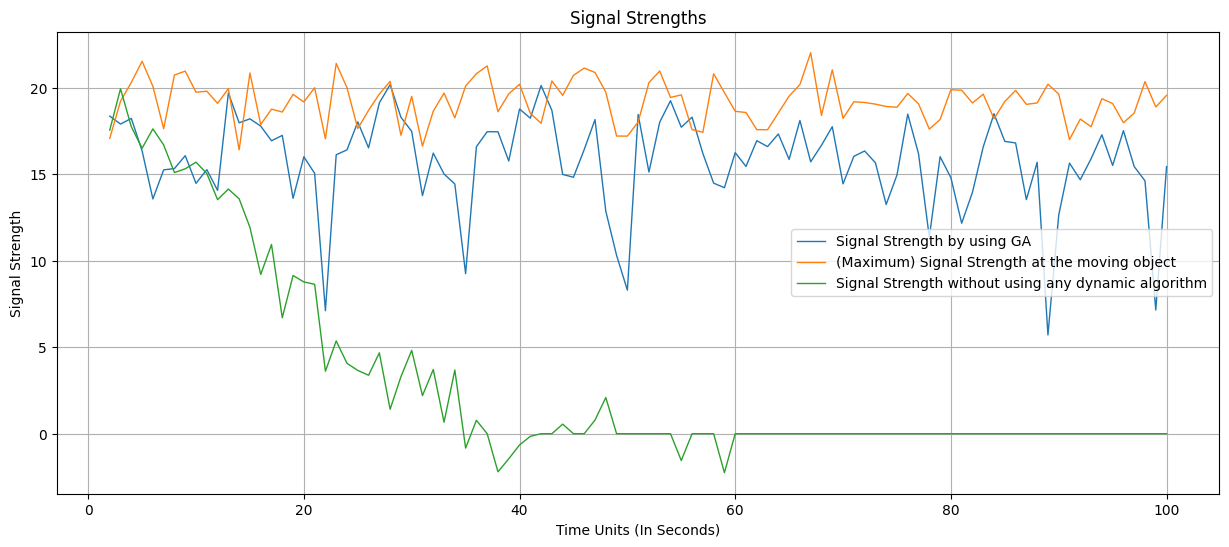

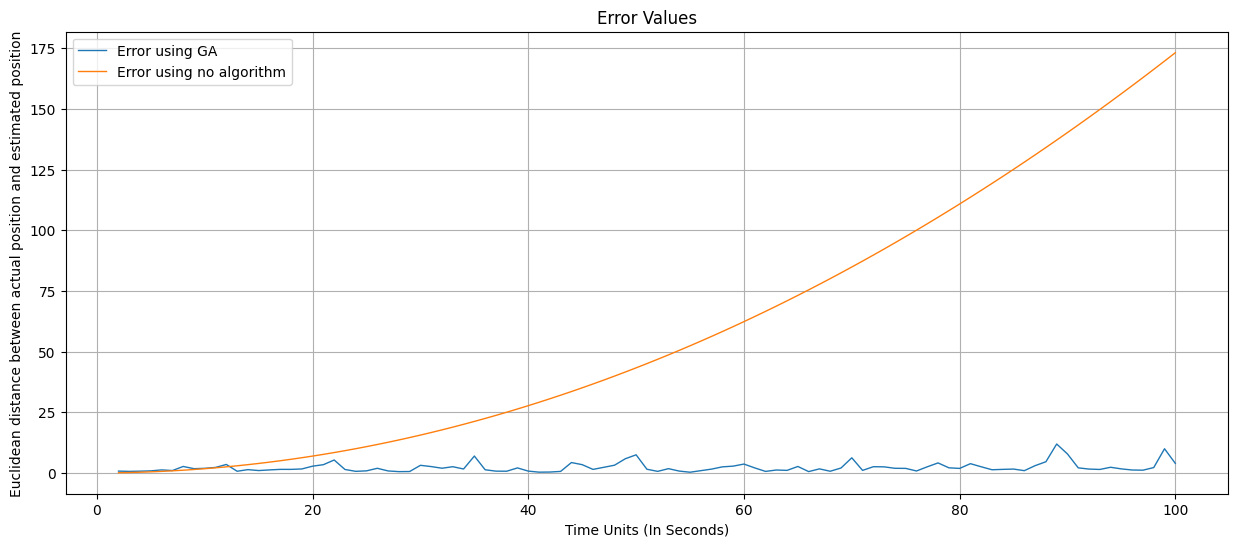

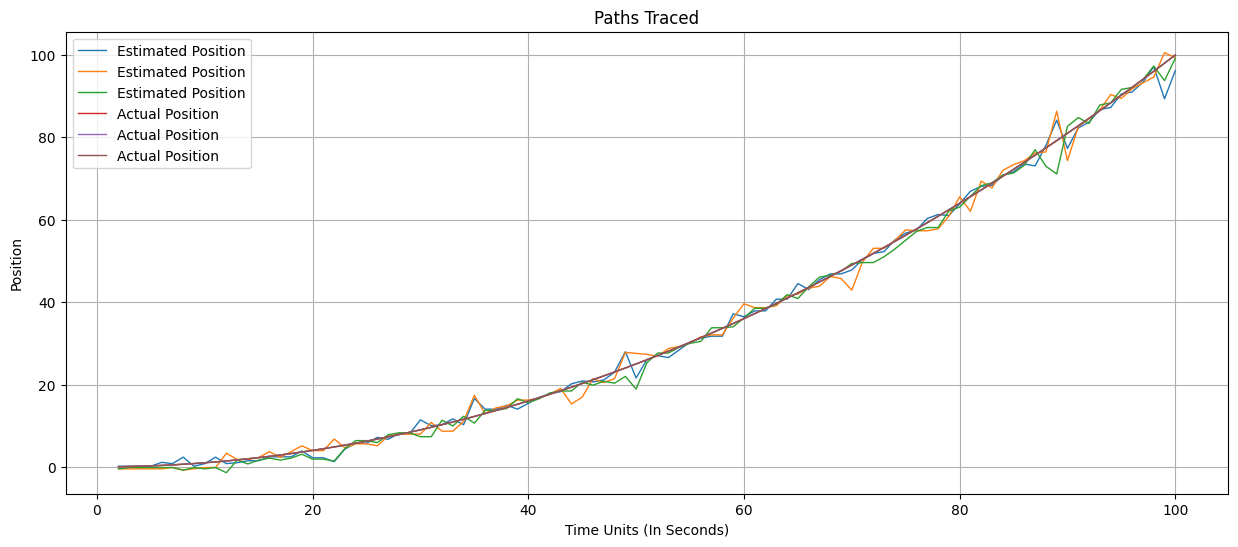

In [28]:
# Create a line plot
signal_strength = values
max_signal_strength = true_values
static_signal_strength = station_values

# Plot Signal Strengths
plt.figure(figsize=(15, 6))
plt.plot(time_interval, signal_strength, linewidth = '1', label="Signal Strength by using GA")
plt.plot(time_interval, max_signal_strength, label="(Maximum) Signal Strength at the moving object",linewidth = '1')
plt.plot(time_interval, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '1')
plt.title('Signal Strengths')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.legend()
plt.show()

#Error Values
plt.figure(figsize=(15, 6))
plt.plot(time_interval, errors, linewidth = '1', label='Error using GA')
plt.plot(time_interval, manual_errors, linewidth = '1', label='Error using no algorithm')
plt.title('Error Values')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Euclidean distance between actual position and estimated position')
plt.grid(True)
plt.legend()
plt.show()

#Paths Traced
plt.figure(figsize=(15, 6))
plt.plot(time_interval, est_points, linewidth = '1', label='Estimated Position')
plt.plot(time_interval, actual_points, linewidth = '1', label='Actual Position')
plt.title('Paths Traced')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.show()

**Genetic Algorithm Output path traced Simulation**

In [ ]:
def trajectory_to_dict(time, actual_coords, estimated_coords):
    trajectory_dict = {}
    
    for t, actual, estimated in zip(time, actual_coords, estimated_coords):
        trajectory_dict[t] = (actual, estimated)
    
    return trajectory_dict

# Replace this with your actual dictionary containing time, actual, and estimated points
trajectory_data = trajectory_to_dict(time_interval, actual_points, est_points)

# Extract actual and estimated trajectories from the dictionary
actual_trajectory = np.array([val[0] for val in trajectory_data.values()])
estimated_trajectory = np.array([val[1] for val in trajectory_data.values()])
times = list(trajectory_data.keys())

# Base station position
base_station = np.array([-30, 70, 70])

# Create figure
fig = go.Figure()

# Add base station as a red marker, fixed throughout the animation
fig.add_trace(go.Scatter3d(
    x=[base_station[0]], 
    y=[base_station[1]], 
    z=[base_station[2]],
    mode='markers', 
    name='Base Station', 
    marker=dict(size=6, color='red')
))

# Create frames for animation
frames = []
for i in range(len(times)):
    # For each frame, update the plot with actual trajectory, estimated trajectory, and beams
    frame_data = [
        # Base station (included in every frame to remain visible)
        go.Scatter3d(
            x=[base_station[0]], 
            y=[base_station[1]], 
            z=[base_station[2]],
            mode='markers', 
            name='Base Station', 
            marker=dict(size=6, color='red')
        ),
        # Actual trajectory up to the current point
        go.Scatter3d(
            x=actual_trajectory[:i + 1, 0], 
            y=actual_trajectory[:i + 1, 1], 
            z=actual_trajectory[:i + 1, 2],
            mode='lines', 
            name='Actual Trajectory', 
            line=dict(color='green', width=3)
        ),
        # Estimated trajectory up to the current point
        go.Scatter3d(
            x=estimated_trajectory[:i + 1, 0], 
            y=estimated_trajectory[:i + 1, 1], 
            z=estimated_trajectory[:i + 1, 2],
            mode='lines', 
            name='Estimated Trajectory', 
            line=dict(color='blue', width=3)
        ),
        # Beam from base station to the current estimated point
        go.Scatter3d(
            x=[base_station[0], estimated_trajectory[i, 0]], 
            y=[base_station[1], estimated_trajectory[i, 1]], 
            z=[base_station[2], estimated_trajectory[i, 2]], 
            mode='lines', 
            line=dict(color='blue', width=3),
            name='Beam'
        )
    ]
    frames.append(go.Frame(data=frame_data, name=str(i)))

# Initialize the figure with the first frame (starting point)
fig.add_trace(go.Scatter3d(
    x=actual_trajectory[:1, 0], 
    y=actual_trajectory[:1, 1], 
    z=actual_trajectory[:1, 2],
    mode='lines', 
    name='Actual Trajectory', 
    line=dict(color='green', width=3)
))
fig.add_trace(go.Scatter3d(
    x=estimated_trajectory[:1, 0], 
    y=estimated_trajectory[:1, 1], 
    z=estimated_trajectory[:1, 2],
    mode='lines', 
    name='Estimated Trajectory', 
    line=dict(color='blue', width=3)
))
# Add initial beam from base station to the first estimated point
fig.add_trace(go.Scatter3d(
    x=[base_station[0], estimated_trajectory[0, 0]], 
    y=[base_station[1], estimated_trajectory[0, 1]], 
    z=[base_station[2], estimated_trajectory[0, 2]], 
    mode='lines', 
    line=dict(color='blue', width=3),
    name='Beam'
))

# Update layout with a fixed view frame
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        xaxis=dict(range=[-80, 120], autorange=False),  # Set fixed X-axis range
        yaxis=dict(range=[-40, 120], autorange=False),  # Set fixed Y-axis range
        zaxis=dict(range=[0, 120], autorange=False),     # Set fixed Z-axis range
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Mobile Station Trajectory Animation',
    margin=dict(l=0, r=0, b=0, t=0),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 200 / 5, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Set the frames to the figure
fig.frames = frames

# Show the figure
fig.show()

# **Mobile Station in Helical Motion**
**Radius: 10 units, Velocity: 0.2unit/s2**

In [30]:
# Modified Ackley function with multimodality and impairments
def ackley(x, start_time, ti, snr_db=20, fading_type='rician', interference_level=0.1, nakagami_m=1):
    # Apply time decay
    r = 10
    import math
    x[0] = x[0] - r*math.cos(0.2*(ti-start_time))
    x[1] = x[1] - r*math.sin(0.2*(ti-start_time))
    x[2] = x[2] - (0.2*(ti-start_time))
    # Apply impairments
    x = add_awgn_noise(x, snr_db)
    
    if fading_type == 'rayleigh':
        x = apply_rayleigh_fading(x)
    elif fading_type == 'rician':
        x = apply_rician_fading(x)
    elif fading_type == 'nakagami':
        x = apply_nakagami_fading(x, m=nakagami_m)
    
    # Add co-channel interference
    x = add_co_channel_interference(x, interference_level)
    
    # Check if the input is within bounds
    if np.all(x >= -20) and np.all(x <= 20):
        # Ackley function parameters
        a = 20
        b = 0.2
        c = 2 * np.pi
        n = len(x)
        
        # Compute sum terms for the Ackley function
        sum1 = np.sum(x**2)
        sum2 = np.sum(np.cos(c * x))
        
        # Compute terms of the Ackley function
        term1 = -a * np.exp(-b * np.sqrt(sum1 / n))
        term2 = -np.exp(sum2 / n)
        
        # Adding multimodal aspect by creating an additional sine wave modulation
        modulation = np.sin(5 * np.pi * x).sum()
        
        # Final result
        return 20 - (term1 + term2 + a + np.exp(1)) + modulation
    else:
        return 0

**Main Function**

In [ ]:
#Intialisation
start_time = 0
t = list(range(1, 10001))
#start_time = time.time()

errors = []
manual_errors = []
values = []
true_values = []
station_values = []
time_interval = []
est_points = []
actual_points = []

p = 6  # Population size / Number of chromosomes
m = 3 # Number of variables / genes
n = 5 # Number of digits / Alleles
threshold = 3 # Crossover threshold
no_of_child = 3 # Number of childrens 
num_of_mutation = 3 # Number of point of mutation

#Dyamic Range
obj_fun = "Ackley" #"Griewank"/"Rosenbrock"
x_min_range = -10
x_max_range = 10
y_min_range = -10
y_max_range = 10
z_min_range = -10
z_max_range = 10
optm = "max" #"max"

iter = 100
times = 1
file = 'genetic_algorithm_output_steps.txt'

#seeds = [42, 123, 314, 2020, 2024, 314, 2718, 101, 999, 2023, 555, 777, 1001, 333, 888, 100, 200, 300, 400, 500, 600, 700, 1234, 5678, 9012, 3456, 7890]

for it in range(1,500):
    total_score, total_value, total_iteration = 0, 0, 0
    
    if it == 1:
        previous_population = np.random.randint(0, 2, size=(p, m, n)) # Random population generator
    else:
        previous_population = pre_population #Previous 

    results = genetic_algorithm(file, 42, p, m, n, threshold, no_of_child, x_min_range, x_max_range, y_min_range, y_max_range, z_min_range, z_max_range, 
                                obj_fun, num_of_mutation, optm, iter, start_time, previous_population, t[it])
            
    result,fs, pre_population = results
    total_value += result['value']
    location = result['location']
    
    x = np.array([0, 0, 0])
    station_result = ackley(x, start_time, t[it])
    station_values.append(station_result)
    
    import math
    r = 10
    shifted_x = np.array([0 + r*math.cos(0.2*(t[it] - start_time)), 0 + r*math.sin(0.2*(t[it] - start_time)), 0 + (0.2*(t[it] - start_time))])

        
    true_result = ackley(shifted_x, start_time, t[it])
    true_values.append(true_result)
        
    avg_value, avg_iteration = total_value/times, total_iteration/times
    error = euclidean_distance(location, shifted_x)
    manual_error = euclidean_distance(np.array([0, 0, 0]), shifted_x)
    #time_stamp = time.time() - start_time
    time_stamp = t[it]
    values.append(avg_value)
    errors.append(error)
    manual_errors.append(manual_error)
    time_interval.append(time_stamp)
    est_points.append(location)
    actual_points.append(shifted_x)
    
    print(f"\nTime: {time_stamp}s, \nShifted New Position: {shifted_x}, \nBest posible (Minima search) result: {true_result}")
    print("Euclidean Distance:", error)
    
    #Dynamic Range and threshold signal strength to trigger it
    if avg_value < 15 and it>10:
        populate_val = []
        x_gene_value, x_gene = gene_generator(x_min_range, x_max_range, m, n)
        y_gene_value, y_gene = gene_generator(y_min_range, y_max_range, m, n)
        z_gene_value, z_gene = gene_generator(z_min_range, z_max_range, m, n)
        for chromosome in previous_population:
            chromosome_values = []
            dim = 0
            for gene in chromosome:
                bin_str = ''.join(map(str, gene))
                dec_num = int(bin_str, 2)
                if dim == 0:
                    chromosome_values.append(x_gene_value[dec_num])
                if dim == 1:
                    chromosome_values.append(y_gene_value[dec_num])
                if dim == 2:
                    chromosome_values.append(z_gene_value[dec_num])
                dim += 1
            populate_val.append(chromosome_values)
        population_sum = [sum(col) for col in zip(*populate_val[:no_of_child])]
        
        #print(populate_val)
        #print(len(populate_val))
        #print(all_gene_value)
        #print(all_gene)
        min_range = -10
        max_range = 10
        x_min_range = min_range + chromosome_values[0]
        x_max_range = max_range + chromosome_values[0]
        y_min_range = min_range + chromosome_values[1]
        y_max_range = max_range + chromosome_values[1]
        z_min_range = min_range + chromosome_values[2]
        z_max_range = max_range + chromosome_values[2]
        
        print(x_min_range, x_max_range)
        print(y_min_range, y_max_range)
        print(z_min_range, z_max_range)
    
print("\nValue:", values)
print("\nErrors:", errors)
print("\nActual Points", actual_points)
print("\nEstimated  Points", est_points)
print("\nTime Interval", time_interval)

Output Results

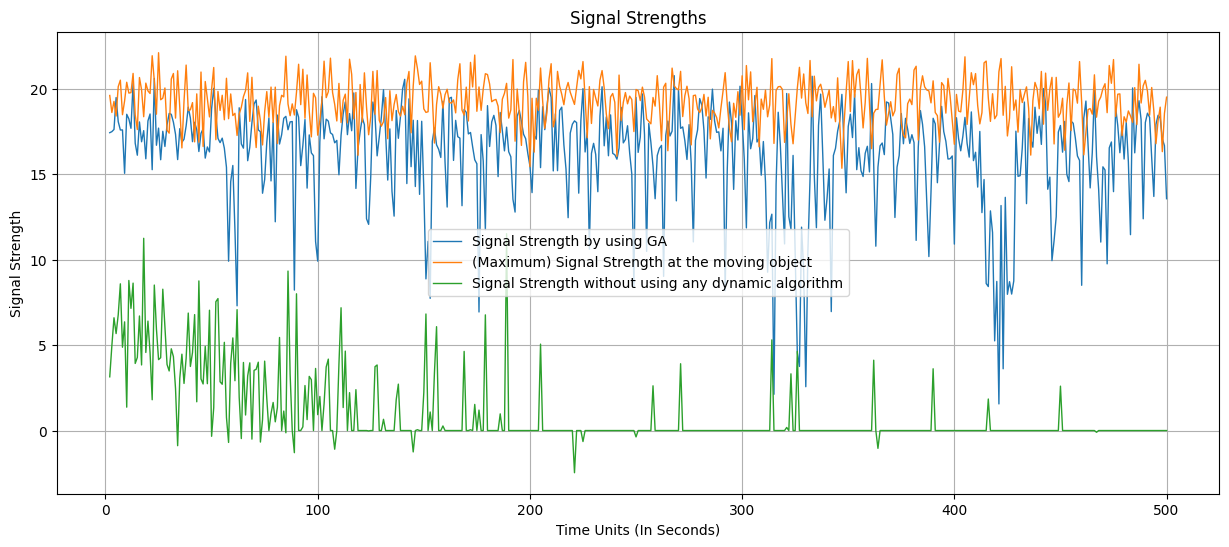

In [32]:
# Create a line plot
signal_strength = values
max_signal_strength = true_values
static_signal_strength = station_values

# Plot Signal Strengths
plt.figure(figsize=(15, 6))
plt.plot(time_interval, signal_strength, linewidth = '1', label="Signal Strength by using GA")
plt.plot(time_interval, max_signal_strength, label="(Maximum) Signal Strength at the moving object",linewidth = '1')
plt.plot(time_interval, static_signal_strength, label='Signal Strength without using any dynamic algorithm', linewidth = '1')
plt.title('Signal Strengths')
plt.xlabel('Time Units (In Seconds)')
plt.ylabel('Signal Strength')
plt.grid(True)
plt.legend()
plt.show()

**Output: Simulation of path traced by genetic algorithm**

In [ ]:
def trajectory_to_dict(time, actual_coords, estimated_coords):
    trajectory_dict = {}
    
    for t, actual, estimated in zip(time, actual_coords, estimated_coords):
        trajectory_dict[t] = (actual, estimated)
    
    return trajectory_dict

# Replace this with your actual dictionary containing time, actual, and estimated points
trajectory_data = trajectory_to_dict(time_interval, actual_points, est_points)

# Extract actual and estimated trajectories from the dictionary
actual_trajectory = np.array([val[0] for val in trajectory_data.values()])
estimated_trajectory = np.array([val[1] for val in trajectory_data.values()])
times = list(trajectory_data.keys())

# Base station position
base_station = np.array([-30, 70, 70])

# Create figure
fig = go.Figure()

# Add base station as a red marker, fixed throughout the animation
fig.add_trace(go.Scatter3d(
    x=[base_station[0]], 
    y=[base_station[1]], 
    z=[base_station[2]],
    mode='markers', 
    name='Base Station', 
    marker=dict(size=6, color='red')
))

# Create frames for animation
frames = []
for i in range(len(times)):
    # For each frame, update the plot with actual trajectory, estimated trajectory, and beams
    frame_data = [
        # Base station (included in every frame to remain visible)
        go.Scatter3d(
            x=[base_station[0]], 
            y=[base_station[1]], 
            z=[base_station[2]],
            mode='markers', 
            name='Base Station', 
            marker=dict(size=6, color='red')
        ),
        # Actual trajectory up to the current point
        go.Scatter3d(
            x=actual_trajectory[:i + 1, 0], 
            y=actual_trajectory[:i + 1, 1], 
            z=actual_trajectory[:i + 1, 2],
            mode='lines', 
            name='Actual Trajectory', 
            line=dict(color='green', width=3)
        ),
        # Estimated trajectory up to the current point
        go.Scatter3d(
            x=estimated_trajectory[:i + 1, 0], 
            y=estimated_trajectory[:i + 1, 1], 
            z=estimated_trajectory[:i + 1, 2],
            mode='lines', 
            name='Estimated Trajectory', 
            line=dict(color='blue', width=3)
        ),
        # Beam from base station to the current estimated point
        go.Scatter3d(
            x=[base_station[0], estimated_trajectory[i, 0]], 
            y=[base_station[1], estimated_trajectory[i, 1]], 
            z=[base_station[2], estimated_trajectory[i, 2]], 
            mode='lines', 
            line=dict(color='blue', width=3),
            name='Beam'
        )
    ]
    frames.append(go.Frame(data=frame_data, name=str(i)))

# Initialize the figure with the first frame (starting point)
fig.add_trace(go.Scatter3d(
    x=actual_trajectory[:1, 0], 
    y=actual_trajectory[:1, 1], 
    z=actual_trajectory[:1, 2],
    mode='lines', 
    name='Actual Trajectory', 
    line=dict(color='green', width=3)
))
fig.add_trace(go.Scatter3d(
    x=estimated_trajectory[:1, 0], 
    y=estimated_trajectory[:1, 1], 
    z=estimated_trajectory[:1, 2],
    mode='lines', 
    name='Estimated Trajectory', 
    line=dict(color='blue', width=3)
))
# Add initial beam from base station to the first estimated point
fig.add_trace(go.Scatter3d(
    x=[base_station[0], estimated_trajectory[0, 0]], 
    y=[base_station[1], estimated_trajectory[0, 1]], 
    z=[base_station[2], estimated_trajectory[0, 2]], 
    mode='lines', 
    line=dict(color='blue', width=3),
    name='Beam'
))

# Update layout with a fixed view frame
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        xaxis=dict(range=[-80, 80], autorange=False),  # Set fixed X-axis range
        yaxis=dict(range=[-40, 120], autorange=False),  # Set fixed Y-axis range
        zaxis=dict(range=[0, 80], autorange=False),     # Set fixed Z-axis range
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Mobile Station Trajectory Animation',
    margin=dict(l=0, r=0, b=0, t=0),
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 200 / 5, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }]
)

# Set the frames to the figure
fig.frames = frames

# Show the figure
fig.show()